In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import pprint
import time
import ctypes
import logging


import numpy as np
import nidaqmx
import nidaqmx._lib  # Due to NIDAQmx C-API bug needed to bypass property getter (according to qudi)
import nidaqmx.stream_readers
import matplotlib.pyplot as plt

import qcsapphire
import qt3rfsynthcontrol

pp = pprint.PrettyPrinter(indent=4)
logging.basicConfig(level = logging.INFO)

In [4]:
nidaq_device_name = 'Dev1'

In [5]:
nisys = nidaqmx.system.System()
device = nidaqmx.system.Device(nidaq_device_name)

In [126]:
device.reset_device()

In [7]:
qcsapphire.discover_devices()

[['COM3',
  'Intel(R) Active Management Technology - SOL (COM3)',
  'PCI\\VEN_8086&DEV_43E3&SUBSYS_0A541028&REV_11\\3&11583659&1&B3'],
 ['COM5',
  'USB Serial Device (COM5)',
  'USB VID:PID=0483:A3E5 SER=206A36705430 LOCATION=1-9:x.0'],
 ['COM10',
  'USB Serial Device (COM10)',
  'USB VID:PID=04D8:000A SER= LOCATION=1-2:x.0']]

In [8]:
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')
pulser = qcsapphire.Pulser('COM10')

In [9]:
rfsynth.rf_off(0)
rfsynth.rf_off(1)
pulser.set_all_state_off()

In [10]:
#uncomment to see current state of RF synth and QCS pulser
pp.pprint(rfsynth.hw_info())
pp.pprint(rfsynth.current_status())

print('global settings')
pp.pprint(pulser.report_global_settings())

for channel in range(1,5):
    pp.pprint(f'channel {channel}')
    pp.pprint(pulser.report_channel_settings(channel))

[   ('model_type', 'WFT SynthHD 1694'),
    ('serial_number', 1694),
    ('fw_version', 'Firmware Version 3.23'),
    ('hw_version', 'Hardware Version 2.06'),
    ('sub_version', 'HD')]
[   'C) Control Channel (A(0) or B(1))  1',
    'f) RF Frequency Now (MHz) 2870.00000000, 1000.00000000',
    'W) RF Power (dBm) -10.000, 0.000',
    'V) Amp Calibration success? 1',
    'Z) Temperature Comp (0=none, 1=on set, 2=1sec, 3=10sec) 3, 3',
    'a) VGA DAC Setting (0=min, 4000=max) 688, 1007',
    '~) RF Phase Step (0=minimum, 360.0=maximum) 0.0000, 0.0000',
    'h) RF High(1) or Low(0) Power 0, 0',
    'E) PLL Chip En On(1) or Off(0) 0, 0',
    'U) PLL charge pump current 5, 5',
    'b) REF Doubler On(1) or Off(0) 0, 0',
    'i) Channel spacing (Hz) 100.000, 100.000',
    'x) Reference (external=0, int 27MHz=1, int 10MHz=2) 1',
    '*) PLL reference frequency (MHz) 27.00000000',
    'l) Sweep lower frequency (MHz) 2720.00000000, 1000.00000000',
    'u) Sweep upper frequency (MHz) 3220.0000000

In [161]:
#Configure the NI DAQ

def configure_tasks(post_fix_task_name = None, 
                    device_name = 'Dev1',
                    clock_counter = 'ctr1',
                    clock_di_line = 'port0',
                    edge_input_channel = 'PFI12',
                    edge_input_counter = 'ctr2',
                    clock_rate = 1000, 
                    N_data_samples_to_acquire = 500,
                    trigger_input = 'PFI0',
                    new_edge_task = False,
                    new_clock_task = False,
                    continuous_daq = False):
   
    clock_task_name = f'sample_clock{post_fix_task_name}' 
    clock_task = nidaqmx.Task(clock_task_name)

    
    if new_clock_task:
        clock_task.di_channels.add_di_chan(f'{device_name}/{clock_di_line}')
        clock_task.timing.cfg_samp_clk_timing(clock_rate,
                                    sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS)
     
        clock_channel = f'/{device_name}/di/SampleClock'

    else:
        #this adds the clock signal to the output channel
        #is this necessary? 
        clock_task.co_channels.add_co_pulse_chan_freq(
                '/{0}/{1}'.format(device_name, clock_counter),
                freq=clock_rate,
                idle_state=nidaqmx.constants.Level.LOW)

        # clock_task.timing.cfg_implicit_timing(
        #     sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
        #     samps_per_chan=n_steps+2) #qudi configures with n_steps + 1, should recheck why. suspicious extra "1" floating around (n_steps = 101)

        clock_task.timing.cfg_implicit_timing(
            sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS,
            samps_per_chan=clock_rate) #qudi configures with n_steps + 1, should recheck why. suspicious extra "1" floating around (n_steps = 101)

        clock_channel = '/{0}InternalOutput'.format(clock_task.channel_names[0])

    edge_detector_task_name = f'edge_input{post_fix_task_name}'

    edge_detector_task = nidaqmx.Task(edge_detector_task_name)

    #todo -- try to replace all of this with edge_detector_task.add_ci_count_edges_chan
    
    

    ctr_name = f'/{device_name}/{edge_input_counter}'
    chnl_name = f'/{device_name}/{edge_input_channel}'
    
    if new_edge_task: #following nspyre recipe
        edge_detector_task.ci_channels.add_ci_count_edges_chan(
                                    ctr_name,
                                    edge=nidaqmx.constants.Edge.RISING,
                                    initial_count=0,
                                    count_direction=nidaqmx.constants.CountDirection.COUNT_UP)
        edge_detector_task.ci_channels.all.ci_count_edges_term = chnl_name
        
        if continuous_daq:
            edge_detector_task.timing.cfg_samp_clk_timing(clock_rate, 
                                                          source=clock_channel,
                                                          active_edge=nidaqmx.constants.Edge.RISING, 
                                                          sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS)    
        else:        
            edge_detector_task.timing.cfg_samp_clk_timing(clock_rate, 
                                                          source=clock_channel,
                                                          active_edge=nidaqmx.constants.Edge.RISING, 
                                                          sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
                                                          samps_per_chan=N_data_samples_to_acquire)
        
    else:
        # why does qudi count the period of signal? In units of "ticks" -- is that the same as edge counting? 
        
        edge_detector_task.ci_channels.add_ci_period_chan(
                            ctr_name,
                            min_val=0,
                            max_val=100000000,
                            units=nidaqmx.constants.TimeUnits.TICKS,
                            edge=nidaqmx.constants.Edge.RISING)
        # I get no data when I swap out the line above for this line
        # edge_detector_task.ci_channels.add_ci_count_edges_chan(
        #                             ctr_name,
        #                             edge=nidaqmx.constants.Edge.RISING,
        #                             initial_count=0,
        #                             count_direction=nidaqmx.constants.CountDirection.COUNT_UP)
        
        # from qudi -- apparently this overcomes some kind of bug in the C-library, according to comments in qudi code
        try:
            # this sets the counter to read from the appropriate terminal
            nidaqmx._lib.lib_importer.windll.DAQmxSetCIPeriodTerm(
                edge_detector_task._handle,
                ctypes.c_char_p(ctr_name.encode('ascii')),
                ctypes.c_char_p(clock_channel.encode('ascii')))
            
            #this tells the counter which clock to use
            nidaqmx._lib.lib_importer.windll.DAQmxSetCICtrTimebaseSrc(
                edge_detector_task._handle,
                ctypes.c_char_p(ctr_name.encode('ascii')),
                ctypes.c_char_p(chnl_name.encode('ascii')))
        except:
            nidaqmx._lib.lib_importer.cdll.DAQmxSetCIPeriodTerm(
                edge_detector_task._handle,
                ctypes.c_char_p(ctr_name.encode('ascii')),
                ctypes.c_char_p(clock_channel.encode('ascii')))
            nidaqmx._lib.lib_importer.cdll.DAQmxSetCICtrTimebaseSrc(
                edge_detector_task._handle,
                ctypes.c_char_p(ctr_name.encode('ascii')),
                ctypes.c_char_p(chnl_name.encode('ascii')))

        
        if continuous_daq:
            edge_detector_task.timing.cfg_implicit_timing(sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS)
        else:
            edge_detector_task.timing.cfg_implicit_timing(sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
                                                      samps_per_chan=N_data_samples_to_acquire)
    
    if trigger_input:
        edge_detector_task.triggers.arm_start_trigger.trig_type =  nidaqmx.constants.TriggerType.DIGITAL_EDGE
        edge_detector_task.triggers.arm_start_trigger.dig_edge_edge =  nidaqmx.constants.Edge.RISING
        edge_detector_task.triggers.arm_start_trigger.dig_edge_src = f'/{device_name}/{trigger_input}'
    

    edge_detector_reader = nidaqmx.stream_readers.CounterReader(edge_detector_task.in_stream)
    
    return clock_task, edge_detector_task, edge_detector_reader



In [178]:
#set up pulser
pulser.system.mode('normal')

period = 15e-6 
pulser.system.period(period) 
pulser.system.external.mode('disabled')

#channel A connects to AOM to control laser
width_initialize_ground_state_laser = 5e-6
aom_delay = 0.9e-6 #there is an observed 900 ns delay between the onset of the AOM signal and the actual diffraction of the light
rf_onset_delay = 200e-9 #we wait some time after the aom is off
rf_width = 1e-6
rf_offset_delay = 100e-9 #amount of time to wait for after RF signal is off before beginning readout
width_readout_laser = 5e-6
initialize_start = 0

pulser.channel('A').cmode('normal')
pulser.channel('A').polarity('normal')
pulser.channel('A').delay(initialize_start)
pulser.channel('A').width(width_initialize_ground_state_laser)

rf_start = width_initialize_ground_state_laser + aom_delay + rf_onset_delay

pulser.channel('B').cmode('normal')
pulser.channel('B').polarity('normal')
pulser.channel('B').delay(rf_start)
pulser.channel('B').width(rf_width)

readout_pulse_start = rf_start + rf_offset_delay + rf_width

#we can subtract the aom_delay from the readout_start pulse such that the readout light is delivered immediately after the RF signal is turned off. 
#but, if want to do this, we then must use channel D to trigger the DAQ at the moment the light is received. 
#
# readout_pulse_start -= aom_delay #if we do this, then channel D must trigger the DAQ at readout_start + aom_delay
#

#However, if we want to use the output from D to view on the scope, then that channel would be occupied 
#and we must live with a small delay between the end of the start of

pulser.channel('C').cmode('normal')
pulser.channel('C').polarity('normal')
pulser.channel('C').delay(readout_pulse_start)
pulser.channel('C').width(width_readout_laser)


pulser.channel('A').mux(1 + 4) #output from A will be A + C timers
pulser.channel('B').mux(2) #output from B will be B timer
pulser.channel('C').mux(4) #output from C will be C timer -- connect to NI DAQ card to start DAQ, unless using channel D to start DAQ

#if we want to observe the trigger signals, we multiplex them into the channel D output
pulser.channel('D').mux(1 + 2 + 4) #output from D will be all three trigger signals

# readout_light_start = readout_pulse_start + aom_delay

# pulser.channel('D').cmode('normal')
# pulser.channel('D').polarity('normal')
# pulser.channel('D').delay(readout_light_start)
# pulser.channel('D').width(width_readout_laser)


print(f'Initial Laser Start: {initialize_start}')
print(f'Initial Laser End: {initialize_start + width_initialize_ground_state_laser}')

print(f'RF Start: {rf_start}')
print(f'RF End: {rf_start +rf_width}')

print(f'Readout Start: {readout_pulse_start}')
print(f'Readout End: {readout_pulse_start + width_readout_laser}')

#move into pulser object? 
channel_names = np.array(pulser.channel_names()[1:])
m = len(channel_names)
for chan in channel_names:
    mux_output = int(pulser.channel(str(chan)).mux())
    idx = np.array(list(np.binary_repr(mux_output).zfill(m))).astype(np.int8)[::-1]
    output_channels = channel_names[np.where(idx == 1)]
    print(f'channel {chan} output from timers --> {",".join(output_channels)}')


Initial Laser Start: 0
Initial Laser End: 5e-06
RF Start: 6.1e-06
RF End: 7.1e-06
Readout Start: 7.2e-06
Readout End: 1.22e-05
channel A output from timers --> A,C
channel B output from timers --> B
channel C output from timers --> C
channel D output from timers --> A,B,C


In [179]:
#turn everything on
for i in range(5):
    pulser.channel(i).state(1)
    

In [14]:
rfsynth.set_channel_fixed_output(0, -10, 2870e6)

In [15]:
rfsynth.rf_on(0)

In [ ]:
#after checking output signals with scope above, can put pulser into software trigger mode


In [186]:
pulser.system.mode('single')
pulser.system.external.mode('trigger')

#turn everything on (seems that when changing system mode, state is turned to off)
for i in range(5):
    pulser.channel(i).state(1)
    

In [ ]:
# test scope for software trigger working

In [191]:
for i in range(20000):
    pulser.software_trigger()

In [183]:
def run_once(detector_task, detector_reader, clock_rate,  N_samples,  read_write_timeout=10, pulser = None):
    
    detector_task.wait_until_done() #this doesn't seem to always work... so add delay below
    detector_task.start()
    data_buffer = np.zeros(N_samples)
    
    if pulser:
        pulser.software_trigger()
    
    time.sleep(period) #need to wait for full sets of triggers
    read_samples = detector_reader.read_many_sample_double(
                            data_buffer,
                            number_of_samples_per_channel=N_samples,
                            timeout=read_write_timeout)
    detector_task.stop()
    try:
        assert read_samples == N_samples
    except Exception as e:
        print(e)
        print(f'{read_samples} != {N_samples}')
        raise e
        
    return data_buffer

In [31]:
daq_time= width_readout_laser + aom_delay #we add the aom delay 

In [32]:
daq_time

5.9e-06

In [117]:
clock_rate = int(10e6) #10 MHz
N_samples = int(daq_time * clock_rate)

In [137]:
N_samples

59

In [184]:
def run_with_options(freq_low, freq_high, freq_step,
                     N_samples_per_step, clock_rate, daq_time,
                     trigger_input, pulser, rfsynth, 
                     use_new_edge_task, new_clock_task, 
                     continuous_daq, normalize, rf_power,
                     cooling_time = 0,
                     N_measures_at_each_frequency = 100):


    data = None

    clock_task, edge_detector_task, edge_detector_reader = configure_tasks(post_fix_task_name = 'v9', 
                                                                            clock_rate = clock_rate, 
                                                                            N_data_samples_to_acquire = N_samples_per_step,
                                                                            edge_input_channel = 'PFI12',
                                                                            clock_counter = 'ctr1',
                                                                            trigger_input = trigger_input,
                                                                            new_edge_task = use_new_edge_task,
                                                                            new_clock_task = new_clock_task,
                                                                            continuous_daq = continuous_daq)

    try:
        

        if clock_task:
            clock_task.start()

        data = {}
        
        current_freq = freq_low
        step = 0

        if rfsynth:
            rfsynth.rf_off(0)
            
        while current_freq < freq_high:
            normalized_count_rate_pre = []
            data_at_one_freq = []
            normalized_count_rate_post = []
            
            for a_measure_idx in range(N_measures_at_each_frequency):
                
                if rfsynth:
                    rfsynth.set_channel_fixed_output(0, rf_power, current_freq)

                if normalize:
                    _pre_data = run_once(edge_detector_task, edge_detector_reader, clock_rate, N_samples_per_step, read_write_timeout = 10, pulser = pulser)
                    normalized_count_rate_pre.append(_pre_data.sum())
                    #time.sleep(1.1*(period - readout_pulse_start + width_readout_laser)) #wait for pulser to finish 
                    
                if rfsynth:
                    rfsynth.rf_on(0)
                
                _rf_on_data = run_once(edge_detector_task, edge_detector_reader, clock_rate, N_samples_per_step, read_write_timeout = 10, pulser = pulser)
                data_at_one_freq.append(_rf_on_data.sum())
                #time.sleep(1.1*(period - readout_pulse_start + width_readout_laser)) #wait for pulser to finish 

                
                
                if rfsynth:
                    rfsynth.rf_off(0)

                if normalize:
                    _post_data = run_once(edge_detector_task, edge_detector_reader, clock_rate, N_samples_per_step, read_write_timeout = 10, pulser = pulser)
                    normalized_count_rate_post.append(_post_data.sum())
                    #time.sleep(1.1*(period - readout_pulse_start + width_readout_laser)) #wait for pulser to finish 

            #print(f'collected {len(data_at_one_freq)} measures at this frequency')
            #print(data_at_one_freq)

            if normalize:
                normalized_count_rate = np.mean([normalized_count_rate_pre,normalized_count_rate_post])
                data[current_freq] = data_at_one_freq.mean() / normalized_count_rate
            else:
                data[current_freq] = np.array(data_at_one_freq).mean() * clock_rate
                
            if step % 10 == 0:
                if normalize:
                    print(f'{current_freq/1e9} GHz: {data[current_freq]} normalized intensity')
                else:
                    print(f'{current_freq/1e9} GHz: {data[current_freq]} mean counts/second')
            current_freq += freq_step
            step += 1
            
            time.sleep(cooling_time)
            
    except Exception as e:
        raise(e)

    finally:

        try:
            if rfsynth:
                rfsynth.rf_off(0)
           
        except Exception as e:
            print(e)

        try:
            if clock_task:
                clock_task.stop()
        except Exception as e:
            print(e)

        try:
            if clock_task:
                clock_task.close()
        except Exception as e:
            print(e)

        try:
            if edge_detector_task:
                edge_detector_task.close()
        except Exception as e:
            print(e)
            
        return data

2.83 GHz: 8000000.0 mean counts/second


C:\Users\QT3\anaconda3\envs\qdl-dev\lib\site-packages\nidaqmx\task.py:98: ResourceWarning: Task of name "sample_clockv3" was not explicitly closed before it was destructed. Resources on the task device may still be reserved.
  warnings.warn(
C:\Users\QT3\anaconda3\envs\qdl-dev\lib\site-packages\nidaqmx\task.py:98: ResourceWarning: Task of name "edge_inputv3" was not explicitly closed before it was destructed. Resources on the task device may still be reserved.
  warnings.warn(
C:\Users\QT3\anaconda3\envs\qdl-dev\lib\site-packages\nidaqmx\task.py:98: ResourceWarning: Task of name "sample_clockv4" was not explicitly closed before it was destructed. Resources on the task device may still be reserved.
  warnings.warn(
C:\Users\QT3\anaconda3\envs\qdl-dev\lib\site-packages\nidaqmx\task.py:98: ResourceWarning: Task of name "edge_inputv6" was not explicitly closed before it was destructed. Resources on the task device may still be reserved.
  warnings.warn(


2.85 GHz: 7666666.666666667 mean counts/second
2.87 GHz: 6000000.0 mean counts/second
2.89 GHz: 7333333.333333333 mean counts/second


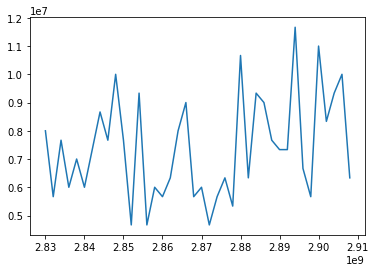

In [192]:
freq_low = 2830e6
freq_high = 2910e6
freq_step = 2e6
trigger_input = 'PFI0'

use_new_edge_task = False
new_clock_task = False
continuous_daq = False
normalize = False
rf_power = -2

data = run_with_options(freq_low, freq_high, freq_step,  N_samples, clock_rate, daq_time,
                                   trigger_input, pulser, rfsynth, use_new_edge_task, 
                                   new_clock_task, continuous_daq, normalize, rf_power,N_measures_at_each_frequency = 30)
plt.plot(data.keys(), data.values())